In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/25511
# 标题：多因子选股策略——基于传统分析

import pandas as pd
from jqdata import *
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False # 处理负号

In [2]:
'''
基本面因子映射
'''
fac_dict = {
    #规模因子
    'MC':valuation.market_cap, # 总市值
    'TA':balance.total_assets, # 总资产
    'TOR':income.total_operating_revenue, # 营业总收入
    
    #竞争力因子
    'GPM':indicator.gross_profit_margin, # 毛利率
    'NPM':indicator.net_profit_margin, # 净利率
    'AP':balance.accounts_payable,  #应付账款
    'APE':balance.advance_peceipts, #预收账款
    'AR':balance.account_receivable, #应收账款
    'APA':balance.advance_payment, #预付账款
    #'APAR':balance.accounts_payable / balance.account_receivable,
    #'APARP':(balance.accounts_payable + balance.advance_peceipts) / (balance.account_receivable + balance.advance_payment),
    #(应付账款+预收账款) / (应收账款+预付账款)
    
    #经营能力
    'OPM':income.operating_profit / income.operating_revenue, #营业利润率
    'INV':balance.inventories, #存货
    'OC':income.operating_cost, #营业成本
    
    #估值因子
    'PE':valuation.pe_ratio, # PE 市盈率
    'PB':valuation.pb_ratio, # PB 市净率
    'PR':valuation.pcf_ratio, # PR 市现率
    'PS':valuation.ps_ratio, # PS 市销率
    'EPS':indicator.eps, # 净资产收益率(扣除非经常损益)(%)
    'BEPS':income.basic_eps, #基本每股收益
    
    
    'GP':indicator.gross_profit_margin * income.operating_revenue, # 毛利润
    'OP':income.operating_profit,
    'OR':income.operating_revenue, # 营业收入
    'NP':income.net_profit, # 净利润
    'EV':valuation.market_cap + balance.shortterm_loan+balance.non_current_liability_in_one_year+balance.longterm_loan+balance.bonds_payable+balance.longterm_account_payable - cash_flow.cash_and_equivalents_at_end,
    
    'TOE':balance.total_owner_equities, # 股东权益合计(元)
    'EBIT':income.net_profit+income.financial_expense+income.income_tax_expense,
    
    'TOC':income.total_operating_cost,#营业总成本
    'NOCF/MC':cash_flow.net_operate_cash_flow / valuation.market_cap, #经营活动产生的现金流量净额/总市值
    'OTR':indicator.ocf_to_revenue, #经营活动产生的现金流量净额/营业收入(%) 
    
    
    'GPOA':indicator.gross_profit_margin * income.operating_revenue / balance.total_assets,  #毛利润 / 总资产 = 毛利率*营业收入 / 总资产
    'ROA':indicator.roa, # ROA
    'ROE':indicator.roe, # ROE
    'INC':indicator.inc_return, # 净资产收益率(扣除非经常损益)(%)
    'AP':indicator.adjusted_profit, # 扣除非经常损益后的净利润(元)
    'OP':indicator.operating_profit, # 经营活动净收益(元)
    'VCP':indicator.value_change_profit, # 价值变动净收益(元) = 公允价值变动净收益+投资净收益+汇兑净收益
    
    'ETTR':indicator.expense_to_total_revenue, # 营业总成本/营业总收入(%)
    'OPTTR':indicator.operation_profit_to_total_revenue, # 营业利润/营业总收入(%)
    'NPTTR':indicator.net_profit_to_total_revenue, # 净利润/营业总收入(%)
    'OETTR':indicator.operating_expense_to_total_revenue, # 营业费用/营业总收入
    'GETTR':indicator.ga_expense_to_total_revenue, # 管理费用/营业总收入(%)
    'FETTR':indicator.financing_expense_to_total_revenue, # 财务费用/营业总收入(%)	
    
    'OPTP':indicator.operating_profit_to_profit, # 经营活动净收益/利润总额(%)
    'IPTP':indicator.invesment_profit_to_profit, # 价值变动净收益/利润总额(%)
    'GSASTR':indicator.goods_sale_and_service_to_revenue, # 销售商品提供劳务收到的现金/营业收入(%)
    'OTR':indicator.ocf_to_revenue, # 经营活动产生的现金流量净额/营业收入(%)
    'OTOP':indicator.ocf_to_operating_profit, # 经营活动产生的现金流量净额/经营活动净收益(%)
    
    'ITRYOY':indicator.inc_total_revenue_year_on_year, # 营业总收入同比增长率(%)
    'ITRA':indicator.inc_total_revenue_annual, # 营业总收入环比增长率(%)
    'IRYOY':indicator.inc_revenue_year_on_year, # 营业收入同比增长率(%)
    'IRA':indicator.inc_revenue_annual, # 营业收入环比增长率(%)
    'IOPYOY':indicator.inc_operation_profit_year_on_year, # 营业利润同比增长率(%)
    'IOPA':indicator.inc_operation_profit_annual, # 营业利润环比增长率(%)
    'INPYOY':indicator.inc_net_profit_year_on_year, # 净利润同比增长率(%)
    'INPA':indicator.inc_net_profit_annual, # 净利润环比增长率(%)
    'INPTSYOY':indicator.inc_net_profit_to_shareholders_year_on_year, # 归属母公司股东的净利润同比增长率(%)
    'INPTSA':indicator.inc_net_profit_to_shareholders_annual, # 归属母公司股东的净利润环比增长率(%)
    'INPTSA':indicator.inc_net_profit_to_shareholders_annual, # 归属母公司股东的净利润环比增长率(%)
    
    
    'ROIC':(income.net_profit+income.financial_expense+income.income_tax_expense)/(balance.total_owner_equities+balance.shortterm_loan+balance.non_current_liability_in_one_year+balance.longterm_loan+balance.bonds_payable+balance.longterm_account_payable),
    'OPTT':income.operating_profit / income.total_profit, # 营业利润占比
    'TP/TOR':income.total_profit / income.total_operating_revenue, #利润总额/营业总收入
    'OP/TOR':income.operating_profit / income.total_operating_revenue,
    'NP/TOR':income.net_profit / income.total_operating_revenue,

    'NP':income.net_profit, # 净利润
    

    'DER':balance.total_liability / balance.equities_parent_company_owners, # 产权比率 = 负债合计/归属母公司所有者权益合计
    'FCFF/TNCL':(cash_flow.net_operate_cash_flow - cash_flow.net_invest_cash_flow) / balance.total_non_current_liability, #自由现金流比非流动负债
    'NOCF/TL': cash_flow.net_operate_cash_flow / balance.total_liability, # 经营活动产生的现金流量净额/负债合计
    'TCA/TCL':balance.total_current_assets / balance.total_current_liability, # 流动比率

    
    
    'TOR/TA':income.total_operating_revenue / balance.total_assets, #总资产周转率
    'TOR/FA':income.total_operating_revenue / balance.fixed_assets, #固定资产周转率
    'TOR/TCA':income.total_operating_revenue / balance.total_current_assets, #流动资产周转率
    'LTL/OC':balance.longterm_loan / income.operating_cost, #长期借款/营业成本
    
    'TL/TA':balance.total_liability / balance.total_assets, #总资产/总负债
    'TL/TOE':balance.total_liability / balance.total_owner_equities,#负债权益比
    
    #规模因子
    '':income.operating_revenue #营业总收入
    
    }

In [3]:
def get_quanter_form_pubdate(date):
    '''
    基于给定的时间判断季度,此时间（date）必须是财报公布时间，由此判断是第几季度的报表。
    计算第几季度是为了获取过去同季度数据
    注：date不能是自定义时间，因为代码时间区间内，财报可能尚未公布。
    input：date 从财报pubDate中得到的日期
    '''
    if type(date) == str:
        year = int(date[:4])
        month_day = date[5:]
    elif type(date) == datetime.date:
        date = date.strftime('%Y-%m-%d')
        year = int(date[:4])
        month_day = date[5:]
    else:
        return 'input date error'
    
    if month_day <= '05-01':
        quanter = str(year-1)+'q4' #一季度报和去年年报公布时间差不多，在此时间段内，用去年年报分析，忽略一季度报
    elif month_day >= '05-01' and month_day < '07-01':
        quanter = str(year)+'q1'
    elif month_day >= '05-01' and month_day < '09-01':
        quanter = str(year)+'q2'
    elif month_day >= '09-01':
        quanter = str(year)+'q3'
    return quanter
def get_date_from_quanter(quanter_date):
    '''
    给定季度，获得日期。在获取行业股票时要基于时间，不同时间的上市公司可能有变化，
    该方法获得的日期只是大概值
    input:
    quanter_date:必须是‘2019q3’形式
    '''
    year = quanter_date[:4]
    quanter = int(quanter_date[-1])
    if quanter == 1:
        date = year + '-04-01'
    elif quanter == 2:
        date = year + '-08-01'
    elif quanter == 3:
        date = year + '-10-01'   
    elif quanter == 4:
        date = year + '-12-31'
    return date  
quanter = get_quanter_form_pubdate('2018-08-25')
date = get_date_from_quanter('2018q3')
date

'2018-10-01'

# 参数设置

In [87]:
current_date = datetime.datetime.now()
current_date = current_date - datetime.timedelta(1) #非工作日在获取财务数据时为空，故取前一天计算
current_date = datetime.datetime.strftime(current_date,'%Y-%m-%d') #当前时间

quanter_date = get_quanter_form_pubdate(current_date)
year = int(quanter_date[:4])
quanter = int(quanter_date[-1])

#因子选择
#规模因子
scale_factors = ['MC','TA','TOR']

#竞争力因子
comptitiveness_factors_origin = ['AP','APE','AR','APA']
comptitiveness_factors_use = ['GPM','NPM']
comptitiveness_factors = comptitiveness_factors_origin + comptitiveness_factors_use

#运营能力
operating_factors = ['OPM']

#成长性
growth_factors_origin = ['EPS','NP']
growth_factors_use = ['IRYOY','IRA']
growth_factors = growth_factors_origin + growth_factors_use

#估值因子
valuation_factors = ['PE','PS','EPS']

#总因子
factor_list = scale_factors + comptitiveness_factors + operating_factors + growth_factors + valuation_factors
factor_list = list(set(factor_list)) #去除重合因子

date = '2018-10-20'    #获取此日期数据，eg:当天的股票信息

#回测时间段
start_date = '2015-01-01'
end_date = '2019-12-31'
#定义获取财报数据时间和历史数据窗口长度，以季度定义

TIME_WINDOW = [30,60,90] #计算未来收益的时间窗口
SELECT_STOCKS_NUM = 5 #每个行业选择的股票数
WEIGHT =  [2,1,1,2,1]  #不同维度因子权重，此列表长度必须和选择的因子长度相同


YEAR = 2018 #数据获取的年份
QUATER = 2 #季度
N = 3 #获取过去N年数据

#未来买卖股票时间段
buy_date = '2018-09-01'
sell_date = '2019-03-31'

#因子



INDUSTRY_CODE = '801140'

INDUSTRY_RULE = 'sw_l1'
'''
"sw_l1": 申万一级行业
"sw_l2": 申万二级行业
"sw_l3": 申万三级行业
"jq_l1": 聚宽一级行业
"jq_l2": 聚宽二级行业
"zjw": 证监会行业
'''

'''
all_securities = get_all_securities(date=date)   #获取当天所有股票代码
all_stocks = list(all_securities.index)

'''


'\nall_securities = get_all_securities(date=date)   #获取当天所有股票代码\nall_stocks = list(all_securities.index)\n\n'

# 数据准备

In [5]:
def get_stock_industry(name,date):
    '''
    获取股票对应的行业
    input：
    neme: str, 
    "sw_l1": 申万一级行业
    "sw_l2": 申万二级行业
    "sw_l3": 申万三级行业
    "jq_l1": 聚宽一级行业
    "jq_l2": 聚宽二级行业
    "zjw": 证监会行业
    date:str or datetime,日期
    output: DataFrame,index 为股票代码，columns 为所属行业代码
    '''
    all_securities = get_all_securities(date=date)   #获取当天所有股票代码
    all_stocks = list(all_securities.index)
    industries = list(get_industries(name).index)
    all_securities['industry_code'] = 1
    for ind in industries:
        industry_stocks = get_industry_stocks(ind,date)
        #有的行业股票不在all_stocks列表之中
        industry_stocks = set(all_stocks) & set(industry_stocks)
        all_securities['industry_code'][industry_stocks] = ind
    stock_industry = all_securities['industry_code'].to_frame()
    #stock_industry.to_csv('stock_industry.csv')
    return stock_industry



In [6]:
def get_fundamental_data(factor_list, date, securities,ttm_factors=[]):
    '''
    获取基本面数据,横截面数据，时间、股票、因子三个参数确定
    获取的数据中可能含有Nan值
    输入：
    factor_list:list, 普通因子
    ttm_factors:list, ttm因子，获取过去四个季度财报数据的和
    date:str 或者 datetime.data, 获取数据的时间
    securities：list,默认为全部股票
    输出：
    DataFrame,普通因子和ttm因子的合并，index为股票代码，第一列也为股票代码
    '''
    if len(factor_list) == 0:
        return 'fundamental list is empty, please input data'
    #获取查询的factor list
    q = query(valuation.code)
    for fac in factor_list:
        q = q.add_column(fac_dict[fac])
    q = q.filter(valuation.code.in_(securities))
    fundamental_df = get_fundamentals(q,date)
    fundamental_df.index = fundamental_df['code']
    print()
    fundamental_df.columns = ['code'] + factor_list
    if type(date) == str:
        year = int(date[:4])
        month_day = date[5:]
    elif type(date) == datetime.date:
        date = date.strftime('%Y-%m-%d')
        year = int(date[:4])
        month_day = date[5:]
    else:
        return 'input date error'
    
    if month_day < '05-01':
        statdate_list = [str(year-2)+'q4', str(year-1)+'q1', str(year-1)+'q2', str(year-1)+'q3']
    elif month_day >= '05-01' and month_day < '09-01':
        statdate_list = [str(year-1)+'q1', str(year-1)+'q2', str(year-1)+'q3',str(year)+'q1']
    elif month_day >= '09-01' and month_day < '11-01':
        statdate_list = [str(year-1)+'q2', str(year-1)+'q3', str(year)+'q1', str(year)+'q2']
    elif month_day >= '11-01':
        statdate_list = [str(year-1)+'q4', str(year)+'q1', str(year)+'q2', str(year)+'q3']
            
    ttm_fundamental_data = ''
   
    ttm_q = query(valuation.code)
    for fac in ttm_factors:
        ttm_q = ttm_q.add_column(fac_dict[fac])
    ttm_q = ttm_q.filter(valuation.code.in_(securities))  
                             
    for statdate in statdate_list:
        if type(ttm_fundamental_data) == str:
            fundamental_data = get_fundamentals(ttm_q, statDate=statdate)
            fundamental_data.index = fundamental_data['code']
            ttm_fundamental_data = fundamental_data
        else:
            fundamental_data = get_fundamentals(ttm_q, statDate=statdate)
            fundamental_data.index = fundamental_data['code']
            ttm_fundamental_data.iloc[:,1:] += fundamental_data.iloc[:,1:]
    ttm_fundamental_data.columns = ['code'] + ttm_factors
    results = pd.merge(fundamental_df,ttm_fundamental_data,on=['code'],how='inner')
    results = results.sort_values(by='code')
    results = results.set_index('code')
    return results


In [7]:
def get_stocks_fundamentals(stocks,fac_list,date):
    '''
    获取股票列表的财务数据
    input:
    stocks:股票列表
    fac_list:财务数据列表
    date:时间，获得横截面数据,可以是：‘2018-01-01’，或 ‘2018q3’
    
    output:
    dataframe:
    '''
    q = query(valuation.code,cash_flow.pubDate)
    for fac in fac_list:
        q = q.add_column(fac_dict[fac])
    q = q.filter(valuation.code.in_(stocks))
    if len(date) == 6:
        fund_data = get_fundamentals(q, statDate=date)
    else:
        fund_data = get_fundamentals(q, date)
    fund_data = fund_data.sort_values(by='code')
    fund_data = fund_data.set_index('code')
    fund_data.columns = ['pubDate'] + fac_list
    
    '''
    #部分股票没有对应的财务数据，结果中将自动删除该股票
    code = set(fund_data['code'])
    diff = set(stocks) - code
    print(diff)    
    '''
    return fund_data


In [8]:
def get_tradeday_list(start, end, frequency=None, count=None):
    '''
    获取日期列表
    input:
    start:str or datetime,起始时间，与count二选一
    end:str or datetime，终止时间
    frequency:
        str: day,month,quarter,halfyear,默认为day
        int:间隔天数
    count:int,与start二选一，默认使用start
    '''
    if isinstance(frequency, int):
        all_trade_days = get_trade_days(start, end)
        trade_days = all_trade_days[::frequency]
        days = [datetime.datetime.strftime(i, '%Y-%m-%d') for i in trade_days]
        return days

    if count != None:
        df = get_price('000001.XSHG', end_date=end, count=count)
    else:
        df = get_price('000001.XSHG', start_date=start, end_date=end)
    if frequency == None or frequency == 'day':
        days = df.index
    else:
        df['year-month'] = [str(i)[0:7] for i in df.index]
        if frequency == 'month':
            days = df.drop_duplicates('year-month').index
        elif frequency == 'quarter':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month'] == '01') | (df['month'] == '04') | (df['month'] == '07') | (df['month'] == '10')]
            days = df.drop_duplicates('year-month').index
        elif frequency == 'halfyear':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month'] == '01') | (df['month'] == '06')]
            days = df.drop_duplicates('year-month').index
    trade_days = [datetime.datetime.strftime(i, '%Y-%m-%d') for i in days]
    return trade_days

In [9]:
industry_stocks = get_industry_stocks(INDUSTRY_CODE,date)

In [10]:
fund = get_fundamental_data(factor_list, date, industry_stocks )              

In [12]:

def get_stocks_fundamentals(stocks,fac_list,date,pubdate=False):
    '''
    获取股票列表的财务数据
    input:
    stocks:股票列表
    fac_list:财务数据列表
    date:时间，获得横截面数据,可以是：‘2018-01-01’，或 ‘2018q3’
    
    output:
    dataframe:
    '''
    if len(stocks) > 4:
        if stocks[-5] == '.':
            stocks = [stocks]
    if pubdate == False:
        q = query(valuation.code)
        for fac in fac_list:
            q = q.add_column(fac_dict[fac])
        q = q.filter(valuation.code.in_(stocks))
        if len(date) == 6: #季度方式获取
            fund_data = get_fundamentals(q, statDate=date)
        else:
            fund_data = get_fundamentals(q, date)
        fund_data.columns = ['code'] + fac_list
        fund_data = fund_data.set_index('code')
    else:
        q = query(valuation.code,cash_flow.pubDate)
        for fac in fac_list:
            q = q.add_column(fac_dict[fac])
        q = q.filter(valuation.code.in_(stocks))
        if len(date) == 6: #季度方式获取
            fund_data = get_fundamentals(q, statDate=date)
        else:
            fund_data = get_fundamentals(q, date)
        fund_data.columns = ['code', 'pubdate'] + fac_list
        fund_data = fund_data.set_index('code')

    return fund_data


# 数据计算模块

In [13]:
#计算股票在同行业中的排名
def rank_in_industry(industry_fund,indicator_list=None,pro_name=''):
    '''
    用排序值衡量个股在行业中的地位
    input:
    industry_fund:dataframe，行业所有股票的因子数据
    indicator_list:list,用以指示排序顺序，有的因子越大越好，例如利润率，有的指标越小越好，例如PE，
    eg:[1,-1],第一列正序排列，第二列反序排列
    output：
    rank: dateframe 排序后的df
    '''
    industry_fund = outlier_processing(industry_fund)
    col = industry_fund.columns
    if indicator_list != None:
        if len(col) != len(indicator_list):
            print('input indicator_list error.')
    if indicator_list == None:
        indicator_list = []
        for i in range(len(col)):
            indicator_list.append(1)
            
    rank_l = []
    for i in range(len(indicator_list)):
        indicator = indicator_list[i]
        if indicator == 1:
            
            rank = industry_fund.iloc[:,i].rank(ascending=True)
            rank_l.append(rank)
        elif indicator == -1:
            rank = industry_fund.iloc[:,i].rank(ascending=False)
            rank_l.append(rank)
    rank_df = pd.concat(rank_l,axis=1)  
    s = rank_df.sum(axis=1)
    rank_df[pro_name + 'sum'] = s
    std = (s - s.mean()) / s.std()
    rank_df[pro_name + 'score'] = std
    return rank_df

def stand_in_industry(industry_fund,pro_name = None):
    '''
    行业内标准化，用标准化的数据衡量个股地位
    '''
    industry_fund = outlier_processing(industry_fund)
    mean = industry_fund.mean()
    std = industry_fund.std()
    ind = mean.index
    industry_fund = industry_fund[ind]
    stand = (industry_fund - mean) / std
    if pro_name != None:
        columns = industry_fund.columns
        col = [pro_name + col for col in columns]
        stand.columns = col
            
    return stand

def outlier_processing(df):
    '''
    异常值处理
    '''
    if isinstance(df,pd.DataFrame):
        df = df.fillna(0)
        columns = df.columns
        l = []
        for col in columns:
            c = df[col]
            c[np.isinf(c)] = 0
            l.append(c)
        df = pd.concat(l,axis=1)
    elif isinstance(df, pd.Series):
        df[np.isinf(df)] = 0
    return df
#stand = stand_in_industry(fund) 

# 多维度财报数据分析

1.公司规模

（1）总资产在行业中排名

（2）销售收入在行业中排名

In [14]:
fund = get_stocks_fundamentals(industry_stocks,factor_list, date )              

In [15]:
scale_df = fund[scale_factors]
scale_rank = rank_in_industry(scale_df)
scale_stand = stand_in_industry(scale_df)

2.竞争力

毛利率、净利率、应付账款+预收账款 / 应收账款+预付账款

In [16]:
comptitiveness_df = fund[comptitiveness_factors]
#(应付账款+预收账款) / (应收账款+预付账款)
comptitiveness_df['APARP'] = (comptitiveness_df['AP'] + comptitiveness_df['APE']) / (comptitiveness_df['AR'] + comptitiveness_df['APA'])
comptitiveness_factors_new = comptitiveness_factors_use + ['APARP']
comptitiveness_df = comptitiveness_df[comptitiveness_factors_new]
comptitiveness_rank = rank_in_industry(comptitiveness_df)
comptitiveness_stand = stand_in_industry(comptitiveness_df)

3.运营能力

营业利润率、存货周转天数、

In [17]:
#计算存货周转天数
#期初存货，即上年度末存货
def caculate_inventories_days(industry_stocks,date):
    inventories = get_stocks_fundamentals(industry_stocks,['INV'],date,pubdate=True)
    #print(inventories.head())
    quanter_date_all = inventories['pubdate'].map(get_quanter_form_pubdate)
    stocks_trunday_l = []
    for stock in industry_stocks:
        quanter_date = quanter_date_all.ix[stock]
        year = int(quanter_date[:4])
        quanter = int(quanter_date[-1])
        statdate_last_end = str(year-1) + 'q4'
        
        inventories =  get_stocks_fundamentals(stock,['INV'],quanter_date)
        inventories_last_end = get_stocks_fundamentals(stock,['INV'],statdate_last_end)
        inventories_mean = (inventories + inventories_last_end) / 2
    
        operating_revenue_l = []
        operating_revenue_lastyear_l = []
    
        for i in range(1,quanter + 1):
            statdate = str(year) + 'q' + str(i)
            statdate_lastyear = str(year - 1) + 'q' + str(i)
            operating_revenue = get_stocks_fundamentals(stock,['OC'],statdate)
            operating_revenue_lastyear = get_stocks_fundamentals(stock,['OC'],statdate_lastyear)
            operating_revenue_l.append(operating_revenue)
            operating_revenue_lastyear_l.append(operating_revenue_lastyear)

        operating_revenue_df = pd.concat(operating_revenue_l,axis=1)
        operating_revenue_lastyear_df = pd.concat(operating_revenue_lastyear_l,axis=1)
        operating_revenue_sum = operating_revenue_df.sum(axis=1)
        operating_revenue_lastyear_sum = operating_revenue_lastyear_df.sum(axis=1)
        try:
            trun_times = operating_revenue_sum.values / inventories_mean.values
            trun_days = round((360 / trun_times )[0][0]* quanter / 4,2) 
        except:
            trun_days = 0 #如果前面报错，说明存货天数计算时部分数据缺失，默认周转天数为0
            
        stocks_trunday_l.append(trun_days)
    res = pd.DataFrame(stocks_trunday_l,industry_stocks,columns=['trun_days'])
    return res


In [18]:
trun_days = caculate_inventories_days(industry_stocks,current_date)
operating_df = fund[operating_factors]
operating_df = pd.concat([operating_df,trun_days],axis=1)
operating_rank = rank_in_industry(operating_df,[1,-1])
operating_stand = stand_in_industry(operating_df)

4.成长性

净利润增长率，营业收入增长率，净资产收益率增长率

In [19]:
def caculate_growth_rate(industry_stocks,date,fac_list):
    '''
    计算指标的同比和环比增长率
    input:
    industry_stocks:股票列表
    date:时间
    fac_list:因子列表
    output:
    growth_yoy, growth_hb：两个dateframe，分别为同比增长率和环比增长率
    '''
    inventories = get_stocks_fundamentals(industry_stocks,[],date,pubdate=True)
    quanter_date_all = inventories['pubdate'].map(get_quanter_form_pubdate)
    
    stocks_now_l = []
    stocks_ly_l = []
    stocks_lq_l = []
    for stock in industry_stocks:
        quanter_date = quanter_date_all.ix[stock]
        year = int(quanter_date[:4])
        quanter = int(quanter_date[-1])
        statdate_last_end = str(year-1) + quanter_date[-2:]
        if quanter != 1:
            last_quanter = quanter_date[:-1] + str(quanter - 1)
        else:
            last_quanter = str(year - 1) + 'q4'
        
        
        fund_now =  get_stocks_fundamentals(stock,fac_list,quanter_date)
        fund_last_year = get_stocks_fundamentals(stock,fac_list,statdate_last_end)
        fund_last_quanter = get_stocks_fundamentals(stock,fac_list,last_quanter)
        stocks_now_l.append(fund_now)
        stocks_ly_l.append(fund_last_year)
        stocks_lq_l.append(fund_last_quanter)
    fund_now_df = pd.concat(stocks_now_l)
    fund_ly_df = pd.concat(stocks_ly_l)
    fund_lq_df = pd.concat(stocks_lq_l)
    growth_yoy = (fund_now_df - fund_ly_df) / fund_ly_df
    growth_hb = (fund_now_df - fund_lq_df) / fund_lq_df
    yoy_l = []
    for i in fac_list:
        yoy_l.append(i + 'yoy')
    hb_l = []
    for i in fac_list:
        hb_l.append(i + 'hb')  
    growth_yoy.columns = yoy_l
    growth_hb.columns = hb_l
    return growth_yoy, growth_hb


In [20]:
growth_yoy, growth_hb = caculate_growth_rate(industry_stocks,current_date,growth_factors_origin)
growth_df_use = fund[growth_factors_use]
growth_df = pd.concat([growth_df_use,growth_yoy],axis = 1)
growth_rank = rank_in_industry(growth_df)
growth_stand = stand_in_industry(growth_df)

5.估值因子

市盈率，市销率，每股盈利，

In [21]:
valuation_df = fund[valuation_factors]
valuation_rank = rank_in_industry(valuation_df)
valuation_stand = stand_in_industry(valuation_df)

In [23]:
def get_all_dimension_fund(stocks,date,fac_list=factor_list):
    '''
    获取多维度基本面数据
    input:
    stocks:list,股票列表
    date:时间，可以是‘2020-01-19’或‘2019q3’形式
    fac_list:默认factor_list，参数定义的总列表
    output:
    res:dataframe，多维度基本面数据计算后结果
    '''
    fund = get_stocks_fundamentals(stocks,fac_list,date)
    scale_df = fund[scale_factors]
    scale_rank = rank_in_industry(scale_df,pro_name='scale_')
    scale_stand = stand_in_industry(scale_df,pro_name='std_')

    comptitiveness_df = fund[comptitiveness_factors]
    #(应付账款+预收账款) / (应收账款+预付账款)
    comptitiveness_df['APARP'] = (comptitiveness_df['AP'] + comptitiveness_df['APE']) / (comptitiveness_df['AR'] + comptitiveness_df['APA'])
    comptitiveness_factors_new = comptitiveness_factors_use + ['APARP']
    comptitiveness_df = comptitiveness_df[comptitiveness_factors_new]
    comptitiveness_rank = rank_in_industry(comptitiveness_df,pro_name='comptitiveness_')
    comptitiveness_stand = stand_in_industry(comptitiveness_df,pro_name='std_')
    
    trun_days = caculate_inventories_days(stocks,date)
    operating_df = fund[operating_factors]
    operating_df = pd.concat([operating_df,trun_days],axis=1)
    operating_rank = rank_in_industry(operating_df,[1,-1],pro_name='operating_')
    operating_stand = stand_in_industry(operating_df,pro_name='std_')
    
    growth_yoy, growth_hb = caculate_growth_rate(stocks,date,growth_factors_origin)    
    growth_df_use = fund[growth_factors_use]
    growth_df = pd.concat([growth_df_use,growth_yoy],axis = 1)
    growth_rank = rank_in_industry(growth_df,pro_name='growth_')
    growth_stand = stand_in_industry(growth_df,pro_name='std_')

    valuation_df = fund[valuation_factors]
    valuation_rank = rank_in_industry(valuation_df,pro_name='valuation_')
    valuation_stand = stand_in_industry(valuation_df,pro_name='std_')
    
    l = [scale_rank,scale_stand,comptitiveness_rank,comptitiveness_stand,operating_rank,operating_stand,growth_rank,\
        growth_stand,valuation_rank,valuation_stand]
    res = pd.concat(l,axis=1)
    return res


# 获取历史数据及对应未来一期收益

In [22]:
'''
基于历史数据寻找规律，需获取历史数据及对应的未来一段时间的收益
'''

'\n基于历史数据寻找规律，需获取历史数据及对应的未来一段时间的收益\n'

In [24]:
#时间轴设计
'''
回测时间选最近10年数据，2008-2018年，验证时间窗口选2018-2019，
验证周期可能为一季度、半年、一年，所以验证窗口至少延后一年
基于财报发布时间的方式更为合理
'''
def get_year_quater(start_date, end_date):
    '''
    
    '''
    quater = ['q1','q2','q3','q4']
    l = []
    start = get_quanter_form_pubdate(start_date)
    start_year = int(start[:4])
    start_quater = int(start[-1])
    end = get_quanter_form_pubdate(end_date)
    end_year = int(end[:4])
    end_quater = int(end[-1])
    for i in range(start_year, end_year + 1):
        if i == start_year:
            y = str(i)
            for i in range(start_quater,4+1):
                l.append(y + quater[i-1])
        elif i == end_year:
            y = str(i)
            for i in range(end_quater):
                l.append(y + quater[i])
        else:
            y = str(i)
            for q in quater:
                l.append(y+q)
    return l

def get_next_tradeday(date):
    '''
    获取下一交易日日期
    '''
    if type(date) == str:
        date = datetime.datetime.strptime(date, '%Y-%m-%d')
    delta = datetime.timedelta(days=10) #delta 取10天，跨过节假日
    end_date = date + delta
    tradedays = get_trade_days(date, end_date)
    fristday = tradedays[0]
    date = date.date()
    if fristday == date:
        next_date = tradedays[1]
    else:
        next_date = tradedays[0]
    next_date = datetime.datetime.strftime(next_date, '%Y-%m-%d')
    return next_date

def get_future_data(date, n):
    '''
    得到未来n天后的日期
    '''
    if type(date) == str:
        date = datetime.datetime.strptime(date, '%Y-%m-%d')
    delta = datetime.timedelta(days=n) 
    end_date = date + delta
    end_date = datetime.datetime.strftime(end_date, '%Y-%m-%d')
    return end_date


In [25]:
def caculate_future_profit(stocks,date,time_window):
    '''
    input:
    stocks:股票列表
    date:str or datetime 计算收益的起始时间
    time_window:int or list 计算收益的时间窗口
    eg:date=2019-12-12,time_window=100,则计算从date开始100天后的收益值
    '''
    start_date = datetime.datetime.strptime(date,'%Y-%m-%d')
    start_price = get_price(stocks,end_date=start_date,count=1,fields=['close'])['close']
    if isinstance(time_window,int):
        end_date = start_date + datetime.timedelta(time_window)
        end_price = get_price(stocks,end_date=end_date,count=1,fields=['close'])['close']
        end_price.index = start_price.index
        profit = (end_price - start_price) / start_price
        if isinstance(profit,pd.DataFrame):
            profit = pd.DataFrame(profit.values.T,index=profit.columns,columns=profit.index)
    else:
        profit_l = []
        for tw in time_window:
            end_date = start_date + datetime.timedelta(tw)
            end_price = get_price(stocks,end_date=end_date,count=1,fields=['close'])['close']
            end_price.index = start_price.index
            profit = (end_price - start_price) / start_price
            if isinstance(profit,pd.DataFrame):
                profit = pd.DataFrame(profit.values.T,index=profit.columns,columns=profit.index)
            profit_l.append(profit)
        profit = pd.concat(profit_l,axis =1)
        profit.columns = time_window
    return profit    

In [26]:
def get_history_fund_and_profit(industry_stocks,date,factor_list,time_window=90):
    '''
    获取横截面数据和对应未来一段时期的收益值
    '''
    if date[4] == 'q':
        industry_date = get_date_from_quanter(date) #此时间用于获取当日上市股票用
    else:
        industry_date = date
    #industry_stocks = get_industry_stocks(industry_code,industry_date)   
    f = get_stocks_fundamentals(industry_stocks,['PE'],date,pubdate=True)
    pubdate = f['pubdate']
    pubdate_stocks = list(pubdate.index)
    #由于存在时间差，股票数可能不同，取交集
    industry_stocks = list(set(industry_stocks) & set(pubdate_stocks))
    if len(industry_stocks) == 0:
        return None
    profit_l = []
    for stock in industry_stocks:
        pubdate_stock = pubdate.ix[stock]
        pubdate_next_day = get_next_tradeday(pubdate_stock) #从财报发布的第二天收盘价开始计算收益
        profit = caculate_future_profit(stock,pubdate_next_day,time_window)
        profit_l.append(profit)
    profit_df = pd.concat(profit_l)
    profit_df.index = industry_stocks
    profit_df.name = 'profit'
    fund = get_all_dimension_fund(industry_stocks,date,fac_list=factor_list) #此函数中含有默认参数factor_list
    res = pd.concat([fund,profit_df],axis=1)
    return res

In [27]:
'''
注意：获取行业代码时用当前时间，但在过去部分行业可能并未出现，对于部分行业历史数据将不完整
'''
def get_industry_quanter_fund_profit_data(industry_rule,factor_list,time_window):
    
    industries = get_industries(industry_rule)
    industry_code_list = list(industries.index)
    quanter_list = get_year_quater(start_date,end_date)
    industry_name = industries['name'].values

    industry_dic = {}
    for industry_code in industry_code_list:
        industry_stocks = get_industry_stocks(industry_code)
        res_dic = {}
        for quanter_date in quanter_list:
            quanter_fund_profit = get_history_fund_and_profit(industry_stocks,quanter_date,factor_list,TIME_WINDOW)
            res_dic[quanter_date] = quanter_fund_profit
        industry_dic[industry_code] = res_dic
        with open('traditional_data_'+str(industry_code)+'.pkl','wb') as pk:
            pickle.dump(res_dic,pk)
    return industry_dic
#all_data = get_industry_quanter_fund_profit_data(INDUSTRY_RULE,factor_list,TIME_WINDOW)

In [28]:

with open('traditional_data.pkl','wb') as pk:
    pickle.dump(all_data,pk)

with open('traditional_data.pkl','rb') as pk:
    res_dic = pickle.load(pk)

In [29]:
len(res_dic)
keys = list(res_dic.keys())
key_industry_code =  keys[0]
industry_fund = res_dic[key_industry_code]
key_quanter = list(industry_fund.keys())
quanter_s = key_quanter[0]
test_fund_select = industry_fund[quanter_s]
select_factor = ['scale_score','comptitiveness_score','operating_score','growth_score','valuation_score']
test_fund_select = test_fund_select[select_factor]
test_fund_select.head()

,scale_score,comptitiveness_score,operating_score,growth_score,valuation_score
000519.XSHE,-1.003098,-0.902231,-1.364104,-1.026516,-0.836770
000547.XSHE,-0.689630,0.738189,0.533780,1.026516,1.101013
000561.XSHE,-1.285220,-2.214568,-2.135119,-1.094950,-0.440405
000687.XSHE,0.062694,-1.558400,-0.355853,-0.171086,-1.189094
000697.XSHE,-1.003098,-1.066273,-0.177927,-0.992298,-0.704648


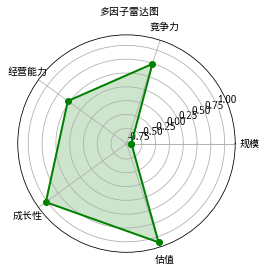

In [86]:
def draw_radar(labels,sample):
    nAttr=len(labels)
    angles=np.linspace(0,2*np.pi,nAttr,endpoint=False)
    sample=np.concatenate((sample,[sample[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    fig=plt.figure(facecolor="white")
    plt.subplot(111,polar=True)
    plt.plot(angles,sample,'bo-',color='g',linewidth=2)
    plt.fill(angles,sample,facecolor='g',alpha=0.2)
    plt.thetagrids(angles*180/np.pi,labels)
    plt.figtext(0.52,0.95,'多因子雷达图',ha='center')
    plt.grid(True)
    #plt.savefig('dota_radar.JPG')
    plt.show()

sample = test_fund_select.iloc[1]
labels=np.array(['规模','竞争力','经营能力','成长性','估值'])
draw_radar(labels,sample)


In [30]:
def stocks_select_traditional(data,weights,select_num):
    '''
    传统方式选股，基于打分情况，乘上权重，排序后选择最大的
    data:dataframe，index为股票代码，column为对应的打分因子，values为打分值
    weight：list,长度必须和data.columns长度相同，对应data的每一列的权重
    select_num：int,选股数量
    '''
    data_weights = (data * weights).sum(axis=1)
    data_weights = data_weights.sort_values(ascending=False)
    stocks = list(data_weights.index[:select_num])
    return stocks
weights =  [2,1,1,2,1] 
select_stocks = stocks_select_traditional(test_fund_select,weights,select_num=SELECT_STOCKS_NUM)

In [31]:
def caculate_select_stocks_profit(stocks,date,time_window,res_format='all'):
    '''
    计算选股收益
    input：
    stocks：list，选择的股票
    date:‘2019q3'模式，选股是基于此季度基本面数据，计算收益的起点时间要基于此计算
    time_window:计算收益的时间窗
    '''
    f = get_stocks_fundamentals(stocks,['PE'],date,pubdate=True)
    pubdate = f['pubdate']
    profit_l = []
    profit_hs300_l = []
    for stock in stocks:
        pubdate_stock = pubdate.ix[stock]
        pubdate_next_day = get_next_tradeday(pubdate_stock) #从财报发布的第二天收盘价开始计算收益
        profit = caculate_future_profit(stock,pubdate_next_day,time_window)
        profit_hs300 = caculate_future_profit('000300.XSHG',pubdate_next_day,time_window)
        profit_l.append(profit)
        profit_hs300_l.append(profit_hs300)
    profit_df = pd.concat(profit_l)
    profit_hs300_df = pd.concat(profit_hs300_l)
    profit_df.index = stocks
    profit_df.name = 'profit'
    profit_hs300_df.index = stocks
    if isinstance(time_window,list):
        profit_relative = profit_df - profit_hs300_df
        hs300_col = ['hs300_'+str(x) for x in time_window]
        profit_hs300_df.columns = hs300_col
        profit_relative_col = ['relative_profit_'+str(x) for x in time_window]
        profit_relative.columns = profit_relative_col

    else:
        profit_relative = profit_df - profit_hs300_df
        profit_hs300_df.name = 'hs300_profit'
        profit_relative.name = 'relative_profit'
    if res_format == 'all':
        res = pd.concat([profit_df,profit_hs300_df,profit_relative],axis=1)
    else:
        res = profit_relative.mean()
        res.name = date
    return res
caculate_select_stocks_profit(select_stocks,quanter_s,TIME_WINDOW,res_format='rel')

relative_profit_30    0.074741
relative_profit_60    0.113957
relative_profit_90    0.134097
Name: 2009q4, dtype: float64

In [32]:
'''
获取不同行业在整个时间周期上的相对收益值
'''
def get_res_data(res_dic,weight,select_stocks_num,time_window):
    '''
    input:
    res_dic:dic,key为行业代码，values为dic,key为季度，values为df，index为股票代码，column为因子值
    weight,权重值，必须和函数里面的select_factor对应
    select_stocks_num:选择的股票数量
    time_window:int or list，时间窗口
    '''
    select_factor = ['scale_score','comptitiveness_score','operating_score','growth_score','valuation_score']
    industry_code_keys = list(res_dic.keys())
    industry_code_dic = {}
    for ic_key in industry_code_keys:
        industry_fund = res_dic[ic_key]
        quanter_keys = list(industry_fund.keys())
        quanter_l = []
        for q_key in quanter_keys:
            fund_s = industry_fund[q_key]
            if isinstance(fund_s,pd.DataFrame):
                fund_select = fund_s[select_factor]
                select_stocks = stocks_select_traditional(fund_select,WEIGHT,select_num=SELECT_STOCKS_NUM)
                profit = caculate_select_stocks_profit(select_stocks,q_key,TIME_WINDOW,res_format='rel')    
                quanter_l.append(profit)
            else:
                continue
        if len(quanter_l) != 0:
            quanter_df = pd.concat(quanter_l,axis=1)
            industry_code_dic[ic_key] = quanter_df
    return industry_code_dic
#industry_code_dic = get_res_data(res_dic,WEIGHT,SELECT_STOCKS_NUM,TIME_WINDOW)

In [33]:

with open('profit_res.pkl','wb') as pk:
    pickle.dump(industry_code_dic,pk)

    
with open('profit_res.pkl','rb') as pk:
    industry_code_dic = pickle.load(pk)

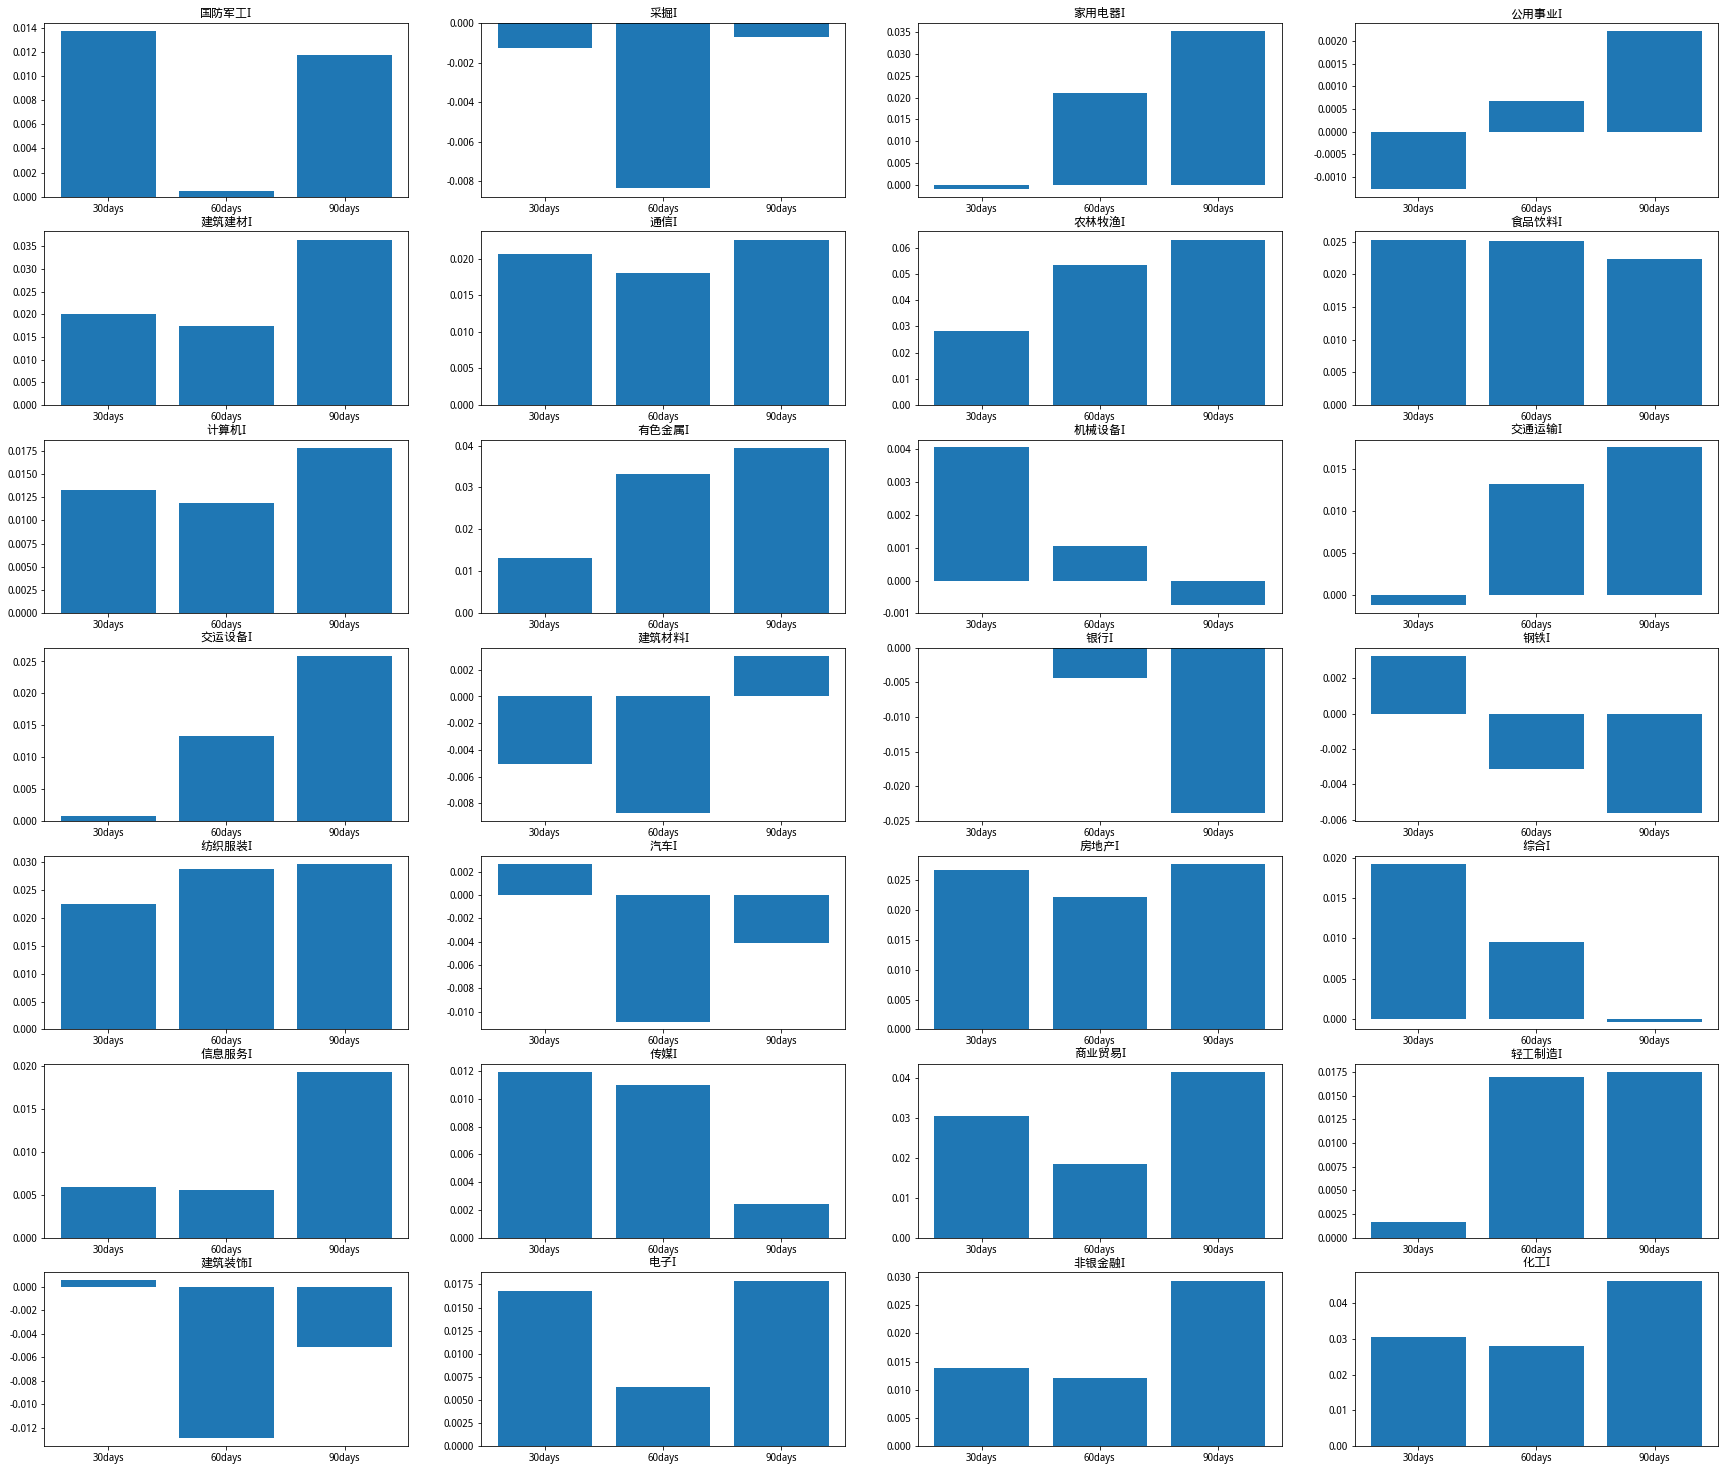

In [53]:
industry_code_keys = list(industry_code_dic.keys())
industries = get_industries("sw_l1")
industry_name = industries['name'].values
length = len(industry_code_keys)
hang = int(length / 4) + 1
figure = plt.figure(figsize=(30,30))

for i in range(length):
    name = industry_name[i]
    code = industry_code_keys[i]
    t = industry_code_dic[code]
    t_mean = t.mean(axis=1)
    plt.subplot(8,4,1+i)
    plt.bar(height=t_mean,x=['30days','60days','90days'])
    plt.title(name)
plt.show()